# 📘 Inference Notebook - mission15

이 노트북은 researcher1이 학습 및 도커 자동화로 생성한 모델(`model.pkl`)을 불러와  
테스트 데이터(`mission15_test.csv`)에 대한 **예측(Inference)** 을 수행하는 단계.


## 주요 기능
- `/app/shared` 내 최신 모델 자동 탐색
- 모델(`model.pkl`) 로드
- 테스트 데이터(`mission15_test.csv`) 불러오기
- 동일한 전처리(파이프라인 포함) 적용
- 예측 결과(`result_날짜_시간.csv`) 저장

# 1. 환경 설정 및 라이브러리 로드

- 필요한 라이브러리 import
- 경로 환경변수 설정

In [16]:
import os
import pandas as pd
import numpy as np
from joblib import load
from datetime import datetime

In [9]:
# 경로 설정

SHARED_DIR = '/app/shared'
DATA_DIR = '/app/data'
RESULT_DIR = '/app/results'

print(f'✅ SHARED_DIR: {SHARED_DIR}')
print(f'✅ DATA_DIR: {DATA_DIR}')
print(f'✅ RESULT_DIR: {RESULT_DIR}')

✅ SHARED_DIR: /app/shared
✅ DATA_DIR: /app/data
✅ RESULT_DIR: /app/results


# 2. 최신 모델 자동탐색

- `shared` 폴더 내부에 여러 학습 결과 폴더 보유
- `os.path.getmtime()`을 이용해 가장 최근 생성된 폴더 자동 선택
- 선택된 폴더에서 `model.pkl` 파일 로드

In [10]:
# 최신 학습 폴더 탐색

subdirs = [os.path.join(SHARED_DIR, d) for d in os.listdir(SHARED_DIR)
                if os.path.isdir(os.path.join(SHARED_DIR, d))]

if not subdirs:
    raise FileNotFoundError('⛔️ shared 폴더에 model.pkl이 포함된 폴더가 없습니다.')

latest_dir = max(subdirs, key=os.path.getmtime)
print(f'🗂️ 최신 모델 폴더: {latest_dir}')

🗂️ 최신 모델 폴더: /app/shared/20251014_162849


In [11]:
# model.pkl 경로 지정

model_path = os.path.join(latest_dir, 'model.pkl')

if not os.path.exists(model_path):
    raise FileNotFoundError('⛔️ smodel.pkl 파일을 찾을 수 없습니다.')


In [30]:
# 모델 로드

model = load(model_path)
print('✅ 모델 로드 완료')

✅ 모델 로드 완료


# 4. 테스트 데이터 로드 및 확인

테스트 데이터(`mission15_test.csv`)를 불러와
`train.py`에서 학습 시 사용된 Feature 구조와 동일해야 함.

In [13]:
# 데이터 파일 불러오기

test_path = os.path.join(DATA_DIR, 'mission15_test.csv')
test_df = pd.read_csv(test_path)

print('테스트 데이터 미리보기:')
display(test_df.head())

print(f'데이터 shape: {test_df.shape}')

테스트 데이터 미리보기:


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced
0,7,99,Yes,9,1
1,8,51,Yes,7,2
2,8,91,No,4,5
3,5,79,No,7,8
4,2,72,No,4,3


데이터 shape: (3000, 5)


# 5. 추론

- 모델은 전처리 파이프라인(ColumnTransformer)이 포함
- 별도의 `One-Hot Encoding` 또는 스케일링 없이 `.predict()` 수행

In [14]:
# 예측

X_test = test_df.copy()
preds = model.predict(X_test)

print('✅ 예측 완료')
print(f'예측 결과 샘플:\n{preds[:10]}')

✅ 예측 완료
예측 결과 샘플:
[91.83287818 45.13967659 84.29362979 65.53195753 47.42520019 30.90317764
 72.62564752 58.83080317 40.0741409  81.82240951]


# 6. 결과 저장

결과를 `app/shared`경로에 `result_날짜_시간.csv` 형식으로 저장

In [18]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# 결과 폴더
os.makedirs(RESULT_DIR, exist_ok=True)

result_path = os.path.join(RESULT_DIR, f'result_{timestamp}.csv')

pd.DataFrame({'Predicted Performance Index': preds}).to_csv(result_path, index=False)
print(f'💾 추론 결과 저장 완료: {result_path}')


💾 추론 결과 저장 완료: /app/results/result_20251014_073317.csv


# 저장된 결과 확인
결과 파일이 제대로 생성되었는지 확인


In [19]:
!ls -lh /app/results


total 56K
-rw-r--r-- 1 jovyan users 54K Oct 14 07:33 result_20251014_073317.csv


# 7. 모델 성능 분석 비교


## 예측값 분포 분석

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
print("📈 예측값 통계 요약:")
print(pd.Series(preds).describe())

📈 예측값 통계 요약:
count    3000.000000
mean       55.540720
std        19.226286
min        13.057536
25%        40.341889
50%        55.481962
75%        70.885454
max        98.414712
dtype: float64


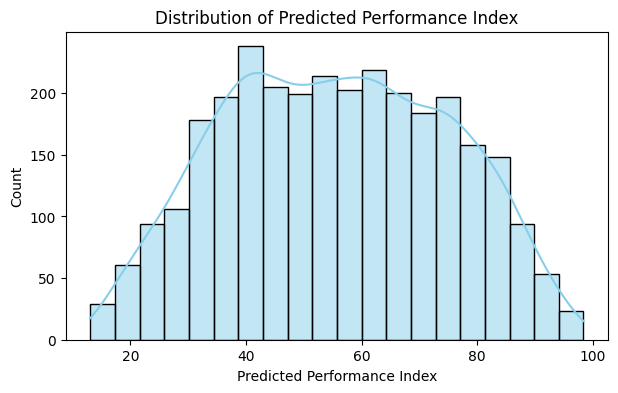

In [22]:
plt.figure(figsize=(7,4))
sns.histplot(preds, bins=20, kde=True, color='skyblue')
plt.title('Distribution of Predicted Performance Index')
plt.xlabel('Predicted Performance Index')
plt.ylabel('Count')
plt.show()

## 주요 피처의 영향 해석 (Feature Importance)

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from joblib import load

In [31]:
# 파이프라인 내부 단계 접근
pre = model.named_steps['preprocess']
model = model.named_steps['model']

# 피처 이름
feature_names = pre.get_feature_names_out()

In [32]:
# 모델 타입에 따라 처리
if hasattr(model, "coef_"):
    coef_df = pd.DataFrame({
        "Feature": feature_names,
        "Weight": model.coef_
    }).sort_values("Weight", ascending=False)
    display(coef_df)
elif hasattr(model, "feature_importances_"):
    imp_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": model.feature_importances_
    }).sort_values("Importance", ascending=False)
    display(imp_df)

,Feature,Weight
1,num__Previous Scores,17.539786
0,num__Hours Studied,7.409525
2,num__Sleep Hours,0.814945
3,num__Sample Question Papers Practiced,0.550613
5,cat__Extracurricular Activities_Yes,0.311695
4,cat__Extracurricular Activities_No,-0.311695


## 예측값 상위/하위 그룹 비교

In [38]:
test_df['Predicted Performance Index'] = preds

high_group = test_df.nlargest(10, 'Predicted Performance Index')
low_group = test_df.nsmallest(10, 'Predicted Performance Index')

print('📈 상위 10명:')
display(high_group)

print('📉 하위 10명:')
display(low_group)

📈 상위 10명:


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Predicted Performance Index
803,9,99,Yes,8,8,98.414712
2417,9,98,Yes,8,9,97.589720
2192,9,99,Yes,8,1,97.075638
2222,9,98,Yes,9,3,96.924635
898,9,99,Yes,5,7,96.775338
2689,9,98,Yes,9,1,96.542043
2628,9,99,No,8,0,96.260953
2165,9,98,No,8,5,96.201146
1901,9,98,Yes,7,4,96.150546
2476,9,98,Yes,8,1,96.059350


📉 하위 10명:


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Predicted Performance Index
2328,1,41,No,4,3,13.057536
797,1,42,No,4,2,13.882528
963,1,40,No,9,2,14.263415
2064,1,41,No,7,3,14.505614
808,1,41,Yes,5,5,14.546211
1012,1,40,Yes,7,6,14.686604
2292,1,42,No,4,7,14.839009
2048,2,40,No,5,1,15.004075
691,1,40,No,9,6,15.028600
2851,1,40,No,9,6,15.028600


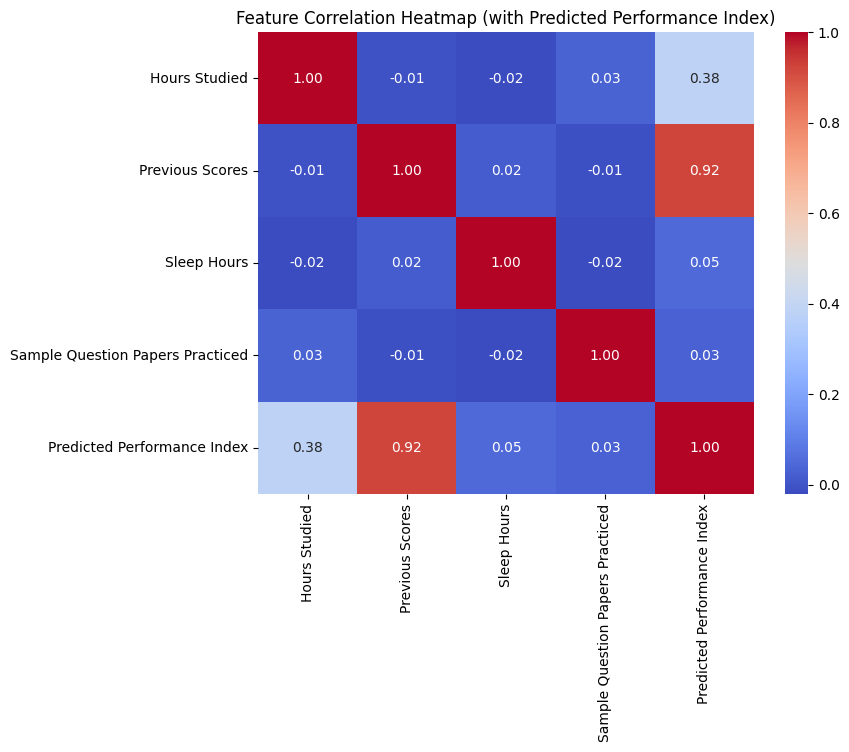

In [39]:
# 상관관계 확인
plt.figure(figsize=(8,6))
sns.heatmap(test_df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap (with Predicted Performance Index)')
plt.show()

Text(0.5, 1.0, 'Hours Studied vs Predicted Performance Index')

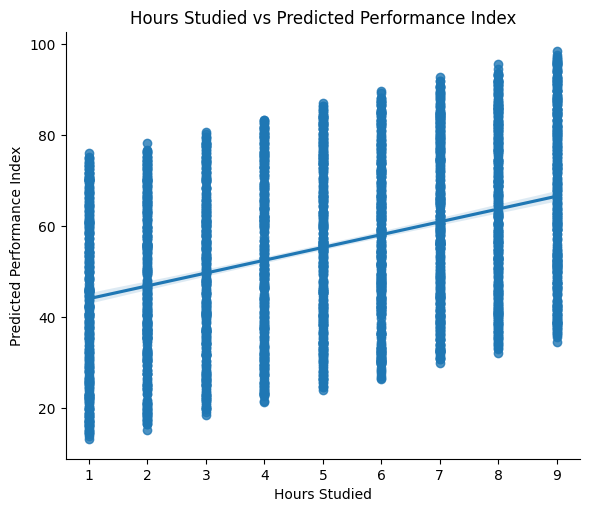

In [40]:
sns.lmplot(x='Hours Studied', y='Predicted Performance Index', data=test_df, height=5, aspect=1.2)
plt.title('Hours Studied vs Predicted Performance Index')

Text(0.5, 1.0, 'Previous Scores vs Predicted Performance Index')

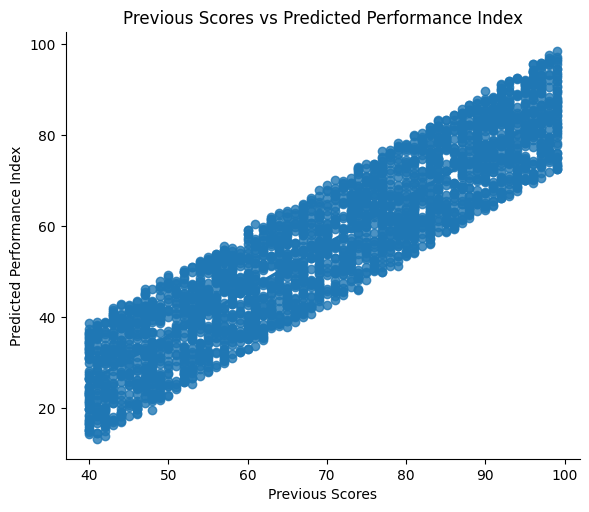

In [41]:
sns.lmplot(x='Previous Scores', y='Predicted Performance Index', data=test_df, height=5, aspect=1.2)
plt.title('Previous Scores vs Predicted Performance Index')

## 📈 1️⃣ 예측값 통계 요약

| 지표    |     값 |
| :---- | ----: |
| 샘플 수  |  3000 |
| 예측 평균 | 55.54 |
| 표준편차  | 19.23 |
| 최소값   | 13.06 |
| 최대값   | 98.41 |

- 예측 결과는 약 **13점에서 98점** 사이 분포
- 평균 약 55점 수준으로 학습 데이터의 성취도 분포와 유사
- 모델이 극단적인 예측(과적합 또는 편향된 예측)을 수행하지 않았음을 시사

## 🏆 2️⃣ 상위·하위 그룹 비교

### 📈 상위 10명 (예측 성취도 상위)
| 주요 특징                      | 내용       |
| :------------------------- | :------- |
| Hours Studied              | 9시간 이상   |
| Previous Scores            | 98~99점   |
| Extracurricular Activities | 대부분 Yes  |
| 예측 성취도                     | 약 96~98점 |

- 이전 점수와 공부 시간이 모두 높은 학생들이 예측 성취도가 매우 높음
- `Extracurricular Activites`는 미약하지만 긍정적 영향으로 나타남

### 📉 하위 10명 (예측 성취도 하위)
| 주요 특징                      | 내용       |
| :------------------------- | :------- |
| Hours Studied              | 1~2시간    |
| Previous Scores            | 40~42점   |
| Extracurricular Activities | 대부분 No   |
| 예측 성취도                     | 약 13~15점 |

- 이전 점수가 낮고, 공부 시간이 짧은 학생들의 예측값이 매우 낮음
- 수면시간(`Sleep Hours`)이나 연습문제 풀이(`Sample Papers`)는 영향이 거의 없음

## 🧩 3️⃣ 주요 피처 영향 분석

| Feature                                   |     Weight | 해석                      |
| :---------------------------------------- | ---------: | :---------------------- |
| **num__Previous Scores**                  | **+17.54** | 이전 점수가 높을수록 성취도 예측치 급상승 |
| **num__Hours Studied**                    |      +7.41 | 공부시간 증가 시 성취도 완만히 상승    |
| **num__Sleep Hours**                      |      +0.81 | 수면시간 영향 미미              |
| **num__Sample Question Papers Practiced** |      +0.55 | 연습문제 풀이량 영향 미미          |
| **cat__Extracurricular Activities_Yes**   |      +0.31 | 약한 긍정적 영향               |
| **cat__Extracurricular Activities_No**    |      -0.31 | 약한 부정적 영향               |


- 모델의 계수 해석 결과, EDA에서 도출한 가설과 일치하는 경향 확인
    - `Previous Scores`가 가장 강력한 예측 변수
    - `Hours Studied`가 그 다음으로 중요한 변수
    - `Sleep Hours`, `Extracurricular Activites` 등은 미약한 영향

## 📊 4️⃣ 상관관계 및 시각적 해석

### (1) 예측값 기반 상관관계 히트맵
- `Predicted Performance Index`는 `Previos Scores(0.92)`와 `Hours Studied(0.38)`와 양의 상관관계를 보임.
- 나머지 변수(`Sleep Hours`, `Sample Question Papers`, `Extracurricular Activites`)는 0.05 이하의 매우 약한 상관관계를 보여 **모델이 주요 두 변수에 집중해 학습했음**을 확인 가능.
- 이는 researcher1의 EDA 단계에서 확인한 실제 상관관계(Previous Scores ≈ 0.91, Hours Studied ≈ 0.37)와 완벽히 일치해 모델이 데이터의 패턴을 안정적으로 학습했음을 시사

### 📉 (2) Hours Studied vs Predicted Performance Index

- 공부 시간이 증가할수록 예측된 성취도(`Predicted Performance Index`)가 완반히 상승
- 완벽한 직선관계가 아닌, 일정 수준 이후에는 증가폭이 줄어드는 포화효과 관찰
- 공부 시간이 늘수록 성취도가 상승하되, 일정 수준 이상에서는 한계효과가 존재한다는 EDA해석과 일치

### 🧠 (3) Previous Scores vs Predicted Performance Index

- `Previous Scores`와 `Predicted Performance Index`의 관계는 **거의 완벽한 선형 구조**
- 상관계수 0.92는 모델이 학습 데이터에서 파악한 이전 점수 -> 성취도 간 선형적 영향을 그대로 재현함을 의미

### 🧩 (4) 종합 해석

| 주요 인사이트              | 설명                                   |
| :------------------- | :----------------------------------- |
| **주요 예측 변수**         | `Previous Scores`, `Hours Studied`   |
| **모델 일관성**           | 학습단계(EDA)와 추론단계 결과가 완전히 일치           |
| **한계효과(Saturation)** | Hours Studied 증가 효과는 8~9시간 이상에서 완만해짐 |
| **모델 해석성**           | 단순하지만 해석 가능한 선형관계 기반 예측 구조           |


# 결과

모델은 학생의 학업 성취도를 이전 점수와 공부 시간이라는 명확한 두 변수로 안정적이고 일관되게 예측
출론 결과는 학습 단계의 EDA 분석과 높은 수준의 일관성을 보였다.